# Classification simulation with 10 permutations

In [1]:
import os,errno
import numpy as np
import pandas as pd
from time import time
from plotnine import *
from scripts import raffe
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from yellowbrick.model_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import normalized_mutual_info_score as nmi

/home/jbenja13/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.


In [2]:
def save_plot(p, fn, width=7, height=7):
    '''Save plot as svg, png, and pdf with specific label and dimension.'''
    for ext in ['.svg', '.png', '.pdf']:
        p.save(fn+ext, width=width, height=height)
        

def mkdir_p(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
            

def generate_classification_data(seed=13):
    # Create a dataset with only 10 informative features
    X, y = make_classification(
        n_samples=500, n_features=1000, n_informative=10, n_redundant=5,
        n_repeated=0, n_classes=2, n_clusters_per_class=1, random_state=seed
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    cla = RandomForestClassifier(n_estimators=100, oob_score=True, 
                                 n_jobs=-1, random_state=seed)
    return X, y, cv, cla

In [3]:
def rfecv_run(X, y, cv, cla, outdir, seed, step=100):
    # Instantiate RFECV visualizer with a random forest classifier
    start = time()
    visualizer = RFECV(cla, cv=cv, step=step, n_jobs=-1, 
                       scoring="normalized_mutual_info_score")
    visualizer.fit(X, y)        # Fit the data to the visualizer
    visualizer.show(outpath="%s/rfecv_classification_nmi.pdf" % outdir)
    visualizer.show(outpath="%s/rfecv_classification_nmi.png" % outdir)
    visualizer.show()           # Finalize and render the figure
    end = time()
    print(f"Runtime of the program is {end - start}")
    fold_dict = {0:'Fold_1', 1:'Fold_2', 2:'Fold_3', 3:'Fold_4', 4:'Fold_5'}
    rfe_df = pd.DataFrame(visualizer.cv_scores_).rename(columns=fold_dict)
    rfe_df['n_features'] = visualizer.n_feature_subsets_
    rfe_df['seed'] = seed
    rfe_df['best_n'] = visualizer.n_features_
    rfe_df['cpu_total'] = end - start
    return rfe_df
    

In [4]:
def run_raffe_cla(estimator, x_train, x_test, y_train, y_test, fold, outdir):
    features = ["feature_%d" % x for x in range(x_train.shape[1])]
    d, pfirst = raffe.feature_elimination(estimator, x_train, y_train, 
                                          np.array(features), 
                                          fold, outdir, 
                                          elimination_rate=0.1, 
                                          RANK=True)
    df_elim = pd.DataFrame([{'fold':fold,
                             'n features':k,
                             'normalized mutual information':d[k][1], 
                             'accuracy':d[k][2], 
                             'ROC AUC':d[k][3]} for k in d.keys()])
    n_features_max = max(d, key=lambda x: d[x][1])
    try:
        n_features,_ = raffe.extract_max_lowess(d)
    except ValueError:
        n_features = n_features_max 
    estimator.fit(x_train[:,d[n_features][4]], y_train)
    labels_pred = estimator.predict(x_test[:, d[n_features][4]])
    metrics_df = pd.DataFrame({'n_features_max': n_features_max, 
                               'n_features': n_features, 
                               'train_acc':raffe.oob_score_accuracy(estimator, y_train), 
                               'train_nmi':raffe.oob_score_nmi(estimator, y_train),
                               'train_roc':raffe.oob_score_roc(estimator, y_train), 
                               'test_acc':accuracy_score(y_test, labels_pred), 
                               'test_nmi':nmi(y_test, labels_pred,
                                              average_method='arithmetic'), 
                               'test_roc':roc_auc_score(y_test, labels_pred)}, 
                              index=[fold])
    
    return df_elim, metrics_df


def raffe_plot(df_dict, outdir, li):
    dft = pd.melt(df_dict, id_vars=['fold', 'n features'], 
              value_vars=['normalized mutual information', 'accuracy', 'ROC AUC'],
              var_name='Metrics', value_name='Score')
    gg = ggplot(dft, aes(x='n features', y='Score', color='Metrics')) +\
        geom_jitter(size=1, alpha=0.6) + facet_wrap('~Metrics') +\
        geom_vline(xintercept=li, color='black', linetype='dashed') +\
        scale_x_log10() + theme_classic() + theme(legend_position="top")
    save_plot(gg, '%s/raffe_feature_selection' % outdir, 12, 4)
    return gg


def raffe_run(X, y, cv, cla, outdir, seed):
    start = time()
    df_dict = pd.DataFrame()
    output = pd.DataFrame()
    fold = 1
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        df_elim, metrics_df = run_raffe_cla(cla, X_train, X_test, y_train, 
                                            y_test, fold, outdir)
        df_dict = pd.concat([df_dict, df_elim], axis=0)
        output = pd.concat([output, metrics_df.reset_index()], axis=0)
        fold += 1
    end = time()
    output['seed'] = seed
    output['cpu_total'] = end - start
    li = output.set_index('index').loc[:, 'n_features'].mean()
    gg = raffe_plot(df_dict, outdir, li)
    print(gg)
    return output

## Permutation loop

/home/jbenja13/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
/home/jbenja13/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


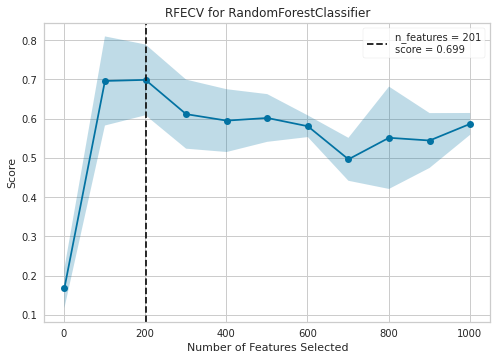

Runtime of the program is 218.73518466949463


In [5]:
# make output directory
directory = 'classification_simu'
mkdir_p(directory)

for seed in range(1, 11):
    X, y, cv, cla = generate_classification_data(seed)
    outdir = '%s/permutation_%d' % (directory, seed)
    mkdir_p(outdir)
    ## RFE
    rfe = rfecv_run(X, y, cv, cla, outdir, seed, step=100)
    rfe.to_csv('%s/rfecv_results_%d_step.txt' % (directory, 100),
               sep='\t', mode='a', index=True,
               header=True if seed == 1 else False)
    rfe = rfecv_run(X, y, cv, cla, outdir, seed, step=10)
    rfe.to_csv('%s/rfecv_results_%d_step.txt' % (directory, 10),
               sep='\t', mode='a', index=True,
               header=True if seed == 1 else False)
    ## RaFFE
    o = raffe_run(X, y, cv, cla, outdir, seed)
    o.to_csv('%s/raffe_results.txt' % (directory),
             sep='\t', mode='a', index=True,
             header=True if seed == 1 else False)